# Разработка прогностической модели для оценки уровня удовлетворенности сотрудников с целью предсказания возможного оттока.

Цель данного исследования заключается в разработке двух прогностических моделей на основе предоставленных заказчиком данных с целью оптимизации управления кадровыми ресурсами. Первая модель предназначена для прогнозирования уровня удовлетворенности сотрудника, а вторая модель направлена на предсказание возможного увольнения сотрудника. Подобный подход позволит заказчику более эффективно адаптировать стратегии управления персоналом и предупреждать возможные потери кадров.

**Описание данных:**

**Тренировочная выборка(уровень удовлетворённости) - train_job_satisfaction_rate.csv**

**Входные признаки тестовой выборки - test_features.csv**

**Целевой признак тестовой выборки(уровень удовлетворённости) -test_target_job_satisfaction_rate.csv**

**Тренировочная выборка(увольнение) - train_quit.csv**

**Целевой признак тестовой выборки(увольнение) - test_target_quit.csv**

`dept` — отдел, в котором работает сотрудник

`level` — уровень занимаемой должности

`workload` — уровень загруженности сотрудника

`employment_years` — длительность работы в компании (в годах)

`last_year_promo` — показывает, было ли повышение за последний год

`last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год

`supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель

`salary` — ежемесячная зарплата сотрудника

`job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании(целевой признак)

`quit` — статус сотрудника(уволился/не уволился)

**Этапы работы**

**Первая задача**
1. [Загрузка данных](#Загрузка-данных)
2. [Предобработка данных satisfaction](#Предобработка-данных-satisfaction)
3. [Исследовательский анализ данных](#Исследовательский-анализ-данных)
4. [Подготовка пайплайна и обучение модели регрессии](#Подготовка-пайплайна-и-обучение-модели-регрессии)
**Вторая задача**

5. [Предобработка данных quit](#Предобработка-данных-quit)
6. [Исследовательский анализ данных в разрезе целевого признака](#Исследовательский-анализ-данных-в-разрезе-целевого-признака)
7. [Подготовка пайплайна и обучение модели классификации](#Подготовка-пайплайна-и-обучение-модели-классификации)
8. [Общий вывод](#Общий-вывод)


In [1]:
!pip install phik -q
!pip install shap -q
!pip install -U scikit-learn -q

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import phik
import shap

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC

sns.set(style="whitegrid")

In [3]:
RANDOM_STATE = 42

In [4]:
def build_bar_plot(df, col, xlabel, title):
    """
    Строит столбчатую диаграмму для анализа распределения категориальной переменной.

    Параметры:
    - df: DataFrame, содержащий данные.
    - col: Название столбца, для которого строится диаграмма.
    - xlabel: Подпись оси x.
    - title: Название графика.

    Пример:
    ```
    build_bar_plot(data, 'department', 'Отделы', 'Распределение сотрудников по отделам')
    ```

    """
    plt.figure(figsize=(10, 7))
    
    order = df[col].value_counts().index
    
    ax = sns.countplot(x=df[col], order=order, color='steelblue')
    
    plt.ylabel('Кол-во сотрудников')
    plt.xlabel(xlabel)
    plt.title(title)
    
    total = len(df[col])
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(percentage, (x, y), ha='center', va='bottom')
        
    plt.xticks(rotation=0)
    plt.show()
    
    
    
    
def build_hist_box_plot(df, col, xlabel, title):
    """
    Строит гистограмму и бокс-плот для анализа распределения числовой переменной.

    Параметры:
    - df: DataFrame, содержащий данные.
    - col: Название столбца, для которого строится гистограмма и бокс-плот.
    - xlabel: Подпись оси x.
    - title: Название графика.

    Пример:
    ```
    build_hist_box_plot(data, 'age', 'Возраст', 'Распределение возраста в компании')
    ```

    """
    plt.figure(figsize=(13, 7))
    
    
    plt.subplot(1, 2, 1)
    sns.histplot(x=df[col], kde=False, bins=30)
    plt.ylabel('Кол-во сотрудников')
    plt.xlabel(xlabel)
    
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.ylabel('')
    plt.xlabel(xlabel)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    display(df[col].describe())
    
    
    

def split_barplot(target_col, title):
    """
    Строит столбчатую диаграмму для сравнения количества уволившихся и действующих сотрудников
    по заданной категориальной переменной.

    Параметры:
    - target_col: Название колонки, содержащей категориальные данные.
    - title: Название графика.

    Пример:
    ```
    split_barplot('department', 'Распределение уволившихся и действующих сотрудников по отделам')
    ```
    
    """
    quit_group = train_quit.query('quit == "yes"')[target_col].value_counts()
    no_quit_group = train_quit.query('quit == "no"')[target_col].value_counts()

    quit_group = quit_group.sort_index()
    no_quit_group = no_quit_group.sort_index()

    total_quit = quit_group.sum()
    total_no_quit = no_quit_group.sum()

    quit_percentages = (quit_group / total_quit) * 100
    no_quit_percentages = (no_quit_group / total_no_quit) * 100

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

    sns.barplot(x=quit_group.index, y=quit_group, ax=axes[0], alpha=1)
    axes[0].tick_params(axis='x', labelsize=14)
    sns.barplot(x=no_quit_group.index, y=no_quit_group, ax=axes[1], alpha=1)
    axes[1].tick_params(axis='x', labelsize=14)

    axes[0].set_xlabel('Уволившиеся сотрудники', fontsize=17)
    axes[0].set_ylabel('Кол-во', fontsize=17)

    axes[1].set_xlabel('Действующие сотрудники', fontsize=17)
    axes[1].set_ylabel('')

    for ax, percentages in zip(axes, [quit_percentages, no_quit_percentages]):
        for i, percentage in enumerate(percentages):
            ax.text(i, percentage + 1, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=12)

    fig.suptitle(title, fontsize=20)

    plt.tight_layout()
    plt.show()

    

def split_boxplot(target_col, title, ylabel):
    
    """
    Строит бокс-плот графики для разных типов покупательской активности 

    Параметры:
    - target_col: Название колоки.
    - title: Название графика.
    - ylabel: Подпись оси y.

    Пример:
    
    ```
    split_boxplot('длительность', 'Время проведенное на сайте', 'Минут')
    ```
    
    """
    
    plt.figure(figsize=(11, 7)) 

    sns.boxplot(x='quit', y=target_col, data=train_quit, palette="viridis")
    plt.title(title)
    plt.xlabel('Уволился')
    plt.ylabel(ylabel)

    plt.show()

# Первая задача 

## Загрузка данных 

In [5]:
try:
    train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', sep=',', decimal='.')
except:
    print('There is no such file')
    
try:
    test_features = pd.read_csv('/datasets/test_features.csv', sep=',', decimal='.')
except:
    print('There is no such file')
    
try:
    test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', sep=',', decimal='.')
except:
    print('There is no such file')
    
try:
    train_quit = pd.read_csv('/datasets/train_quit.csv', sep=',', decimal='.')
except:
    print('There is no such file')
    
try:
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv', sep=',', decimal='.')
except:
    print('There is no such file')

In [6]:
display(train_job_satisfaction_rate.sample(5))
train_job_satisfaction_rate.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1295,143102,sales,middle,medium,6,no,no,3,42000,0.42
1663,372490,sales,sinior,high,6,no,no,5,72000,0.60
625,783768,sales,middle,high,5,no,no,4,49200,0.66
30,106754,hr,junior,medium,2,no,no,4,24000,0.63
1430,200135,marketing,junior,medium,2,no,no,5,28800,0.77


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


В тренировочной выборке обнаружены пропуски в признаках `dept` и `level`

In [7]:
display(test_features.sample(5))
test_features.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
756,247554,technology,middle,medium,5,no,yes,2,44400
1141,926960,sales,middle,medium,9,no,no,2,36000
910,438135,hr,sinior,medium,4,yes,no,2,46800
142,134359,sales,middle,low,5,no,yes,4,24000
242,791203,marketing,middle,low,7,no,no,4,20400


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


В тестовой выборке так же обнаружены пропуски в признаках `dept` и `level`

In [8]:
display(test_target_job_satisfaction_rate.sample(5))
test_target_job_satisfaction_rate.info()

,id,job_satisfaction_rate
292,119574,0.86
1,825977,0.75
213,532619,0.28
1497,521775,0.40
1230,346217,0.61


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


**Вывод: На текущем этапе успешно осуществлена загрузка файлов с данными. В ходе анализа основной информации о датафреймах было выявлено наличие пропущенных значений в столбцах `dept` и `level` как в тестовой, так и в тренировочной выборке.**

## Предобработка данных satisfaction

### Проверка на дубликаты

In [9]:
train_job_satisfaction_rate = train_job_satisfaction_rate.applymap(lambda x: x.lower() if isinstance(x, str) else x)
test_features = test_features.applymap(lambda x: x.lower() if isinstance(x, str) else x)

**Явные дубликаты**

In [10]:
print(f'Явные дубликаты в train_job_satisfaction_rate: {train_job_satisfaction_rate.duplicated().sum()}')
print(f'Явные дубликаты в test_features: {test_features.duplicated().sum()}')

Явные дубликаты в train_job_satisfaction_rate: 0
Явные дубликаты в test_features: 0


**Неявные дубликаты**

In [11]:
print(f'Неявные дубликаты в train_job_satisfaction_rate: {train_job_satisfaction_rate.duplicated(subset=["id"], keep=False).sum()}')
print(f'Неявные дубликаты в test_features: {test_features.duplicated(subset=["id"], keep=False).sum()}')

Неявные дубликаты в train_job_satisfaction_rate: 0
Неявные дубликаты в test_features: 0


### Проверка на  вариативность записи текстовых данных, относящихся к одному и тому же категориальному признаку.

In [12]:
print('train_job_satisfaction_rate')
for column in train_job_satisfaction_rate.select_dtypes(include='object').columns:
    unique_values = train_job_satisfaction_rate[column].unique()
    print(f'Уникальные значения в колонке {column}: {unique_values}')
print()    
print('test_features')    
for column in test_features.select_dtypes(include='object').columns:
    unique_values = test_features[column].unique()
    print(f'Уникальные значения в колонке {column}: {unique_values}')

train_job_satisfaction_rate
Уникальные значения в колонке dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Уникальные значения в колонке level: ['junior' 'middle' 'sinior' nan]
Уникальные значения в колонке workload: ['medium' 'high' 'low']
Уникальные значения в колонке last_year_promo: ['no' 'yes']
Уникальные значения в колонке last_year_violations: ['no' 'yes']

test_features
Уникальные значения в колонке dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения в колонке level: ['junior' 'middle' 'sinior' nan]
Уникальные значения в колонке workload: ['medium' 'low' 'high' ' ']
Уникальные значения в колонке last_year_promo: ['no' 'yes']
Уникальные значения в колонке last_year_violations: ['no' 'yes']


Обнаружено, что в датафрейме `test_features` присутствуют некорректные записи пропущенных значений в столбцах `dept` и `workload`, обработаем их в пайплайне.

**Вывод: На этапе предобработки была проведена проверка на наличие дубликатов, которые не были выявлены. Также была осуществлена проверка вариативности записей, в результате чего выявлены некорректно внесенные данные в тестовой выборке, а именно в столбцах `dept` и `workload`, их обработкой займемся в пайплайне.**

## Исследовательский анализ данных

### Анализ графиков

**train_job_satisfaction_rate**

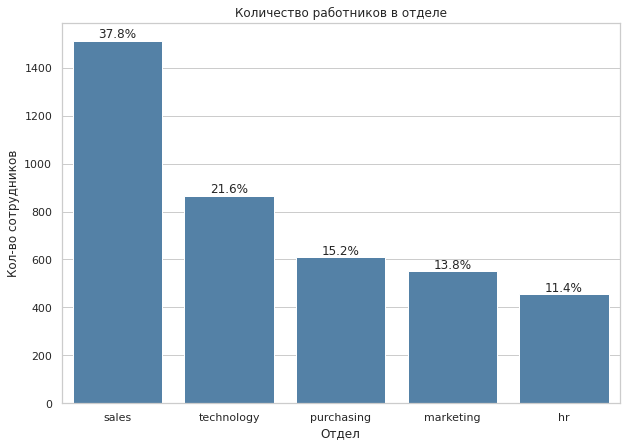

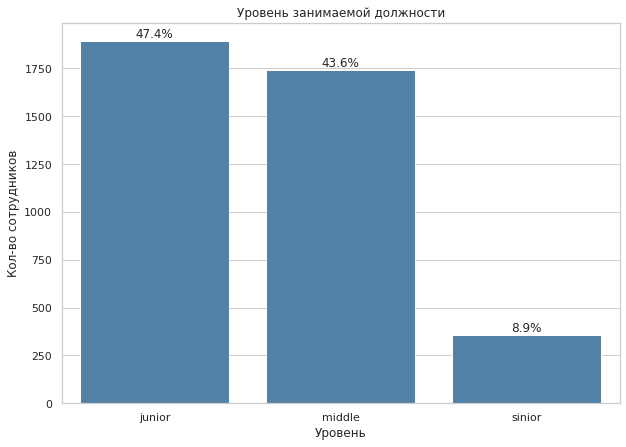

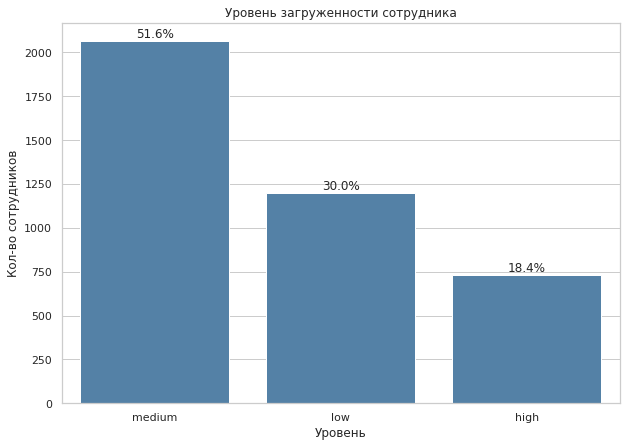

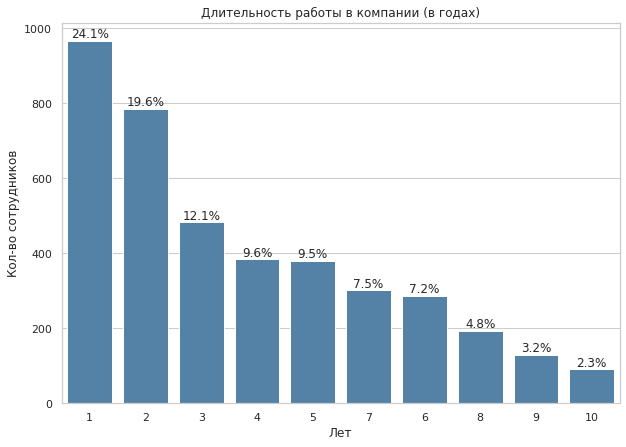

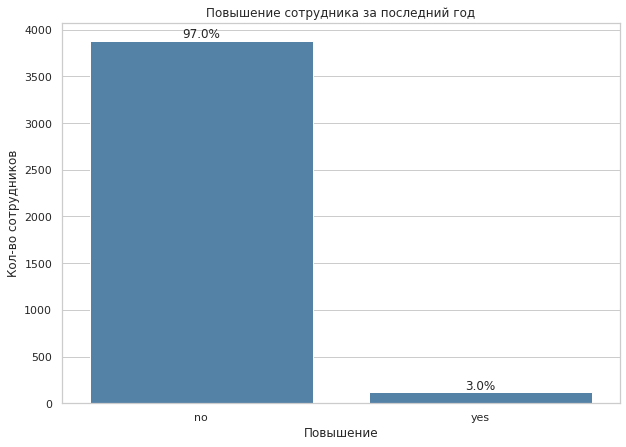

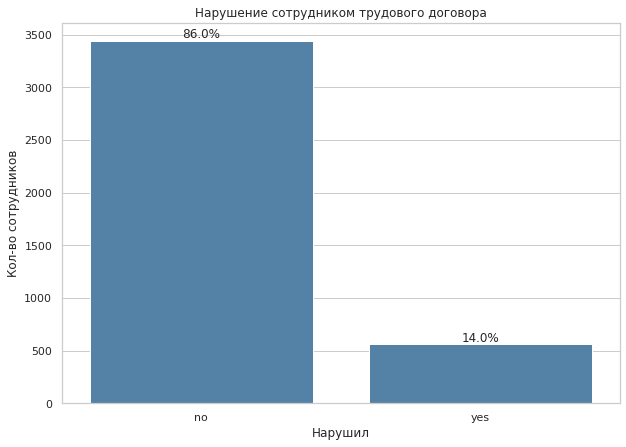

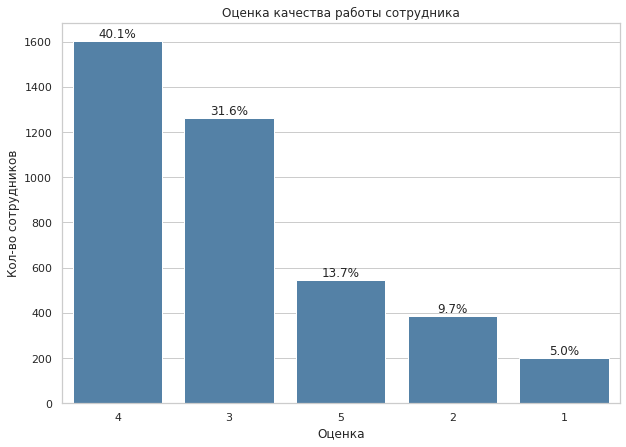

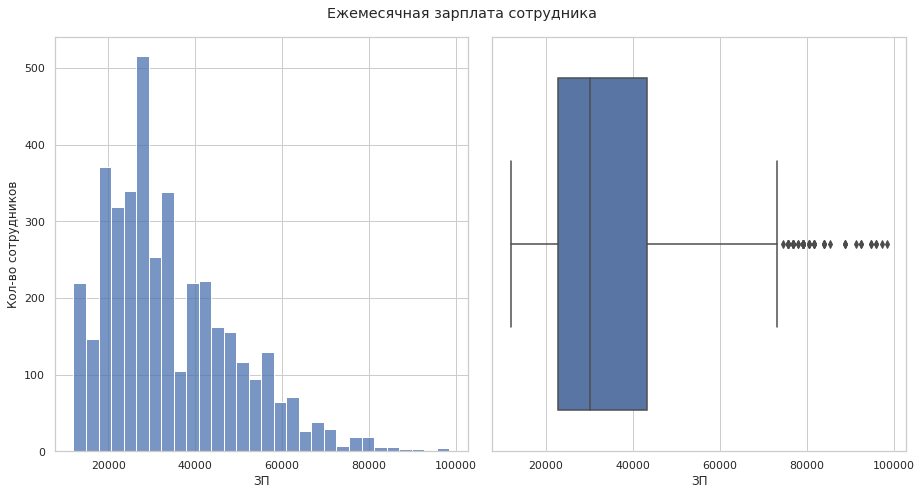

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

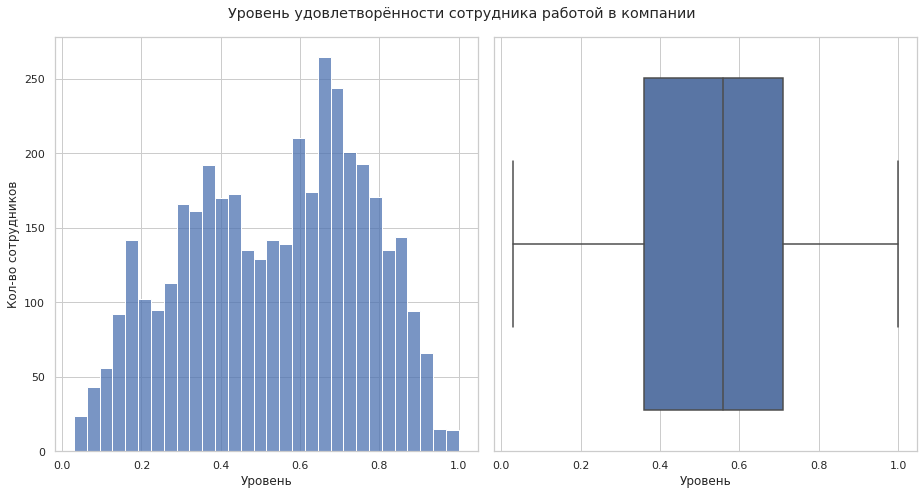

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

In [13]:
build_bar_plot(train_job_satisfaction_rate, 'dept',
               'Отдел', 'Количество работников в отделе')

build_bar_plot(train_job_satisfaction_rate, 'level', 'Уровень', 'Уровень занимаемой должности')

build_bar_plot(train_job_satisfaction_rate, 'workload',
               'Уровень', 'Уровень загруженности сотрудника')

build_bar_plot(train_job_satisfaction_rate, 'employment_years',
               'Лет', 'Длительность работы в компании (в годах)')

build_bar_plot(train_job_satisfaction_rate, 'last_year_promo',
               'Повышение', 'Повышение сотрудника за последний год')

build_bar_plot(train_job_satisfaction_rate, 'last_year_violations',
               'Нарушил', 'Нарушение сотрудником трудового договора')

build_bar_plot(train_job_satisfaction_rate, 'supervisor_evaluation',
               'Оценка', 'Оценка качества работы сотрудника')

build_hist_box_plot(train_job_satisfaction_rate, 'salary',
               'ЗП', 'Ежемесячная зарплата сотрудника')

build_hist_box_plot(train_job_satisfaction_rate, 'job_satisfaction_rate',
               'Уровень', 'Уровень удовлетворённости сотрудника работой в компании')

**test_features + test_target_job_satisfaction_rate**

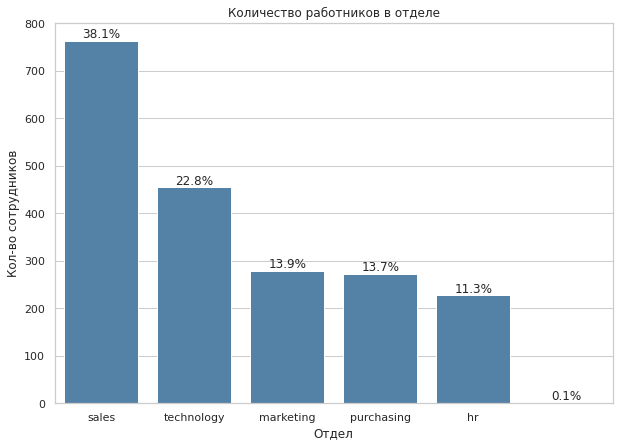

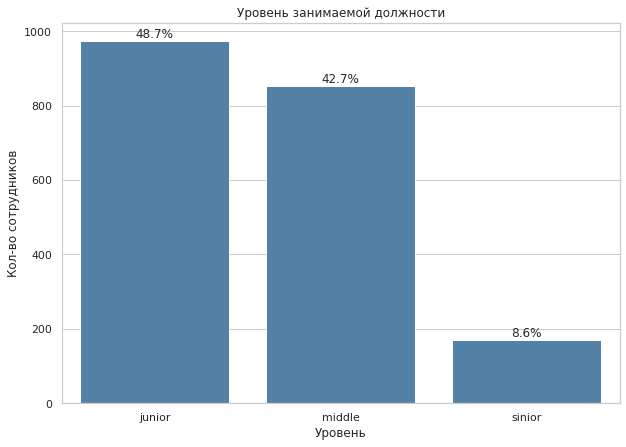

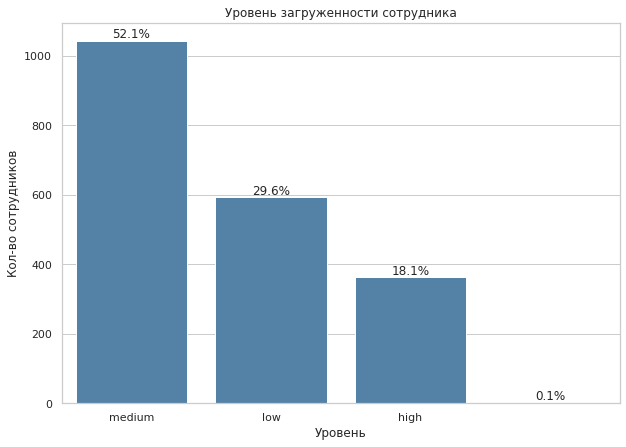

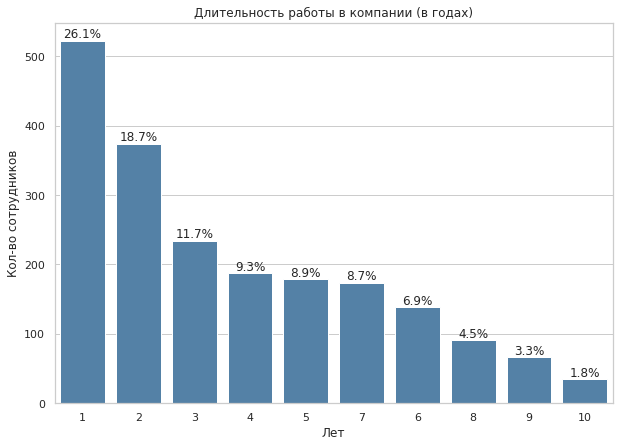

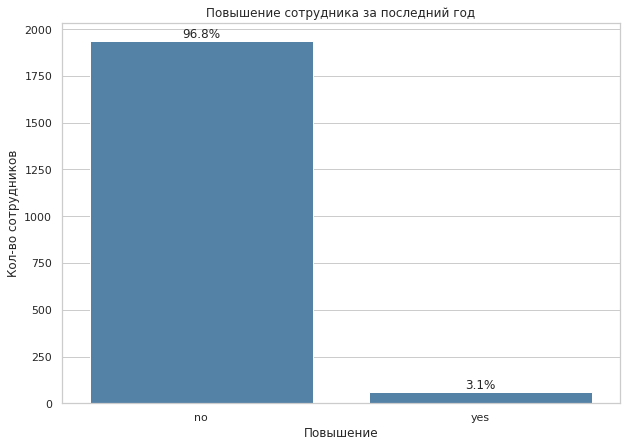

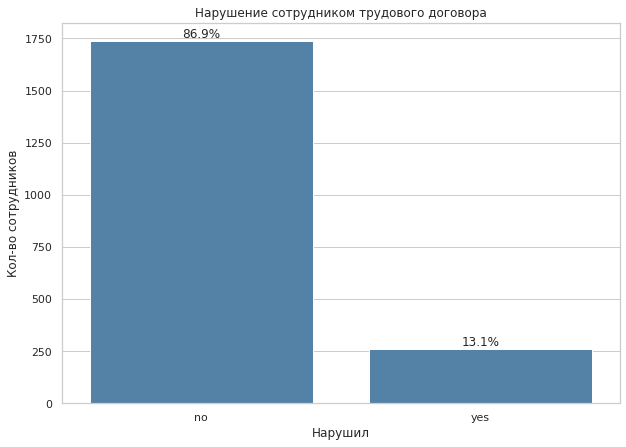

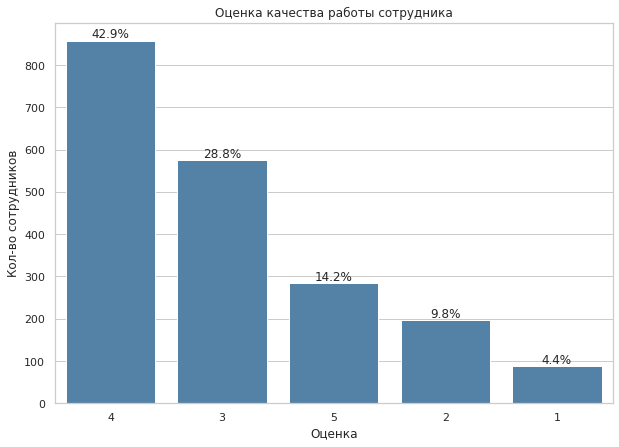

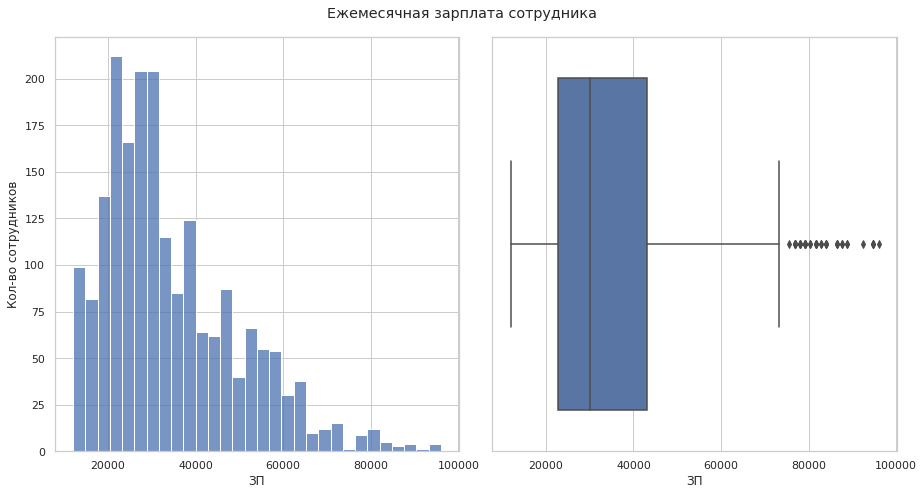

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

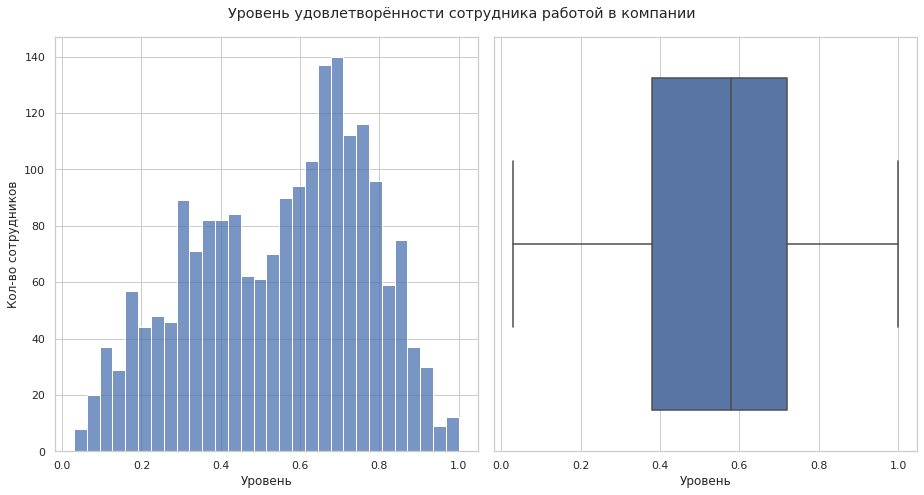

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

In [14]:
build_bar_plot(test_features, 'dept',
               'Отдел', 'Количество работников в отделе')

build_bar_plot(test_features, 'level', 'Уровень', 'Уровень занимаемой должности')

build_bar_plot(test_features, 'workload',
               'Уровень', 'Уровень загруженности сотрудника')

build_bar_plot(test_features, 'employment_years',
               'Лет', 'Длительность работы в компании (в годах)')

build_bar_plot(test_features, 'last_year_promo',
               'Повышение', 'Повышение сотрудника за последний год')

build_bar_plot(test_features, 'last_year_violations',
               'Нарушил', 'Нарушение сотрудником трудового договора')

build_bar_plot(test_features, 'supervisor_evaluation',
               'Оценка', 'Оценка качества работы сотрудника')

build_hist_box_plot(test_features, 'salary',
               'ЗП', 'Ежемесячная зарплата сотрудника')

build_hist_box_plot(test_target_job_satisfaction_rate, 'job_satisfaction_rate',
               'Уровень', 'Уровень удовлетворённости сотрудника работой в компании')

### Корреляционный анализ

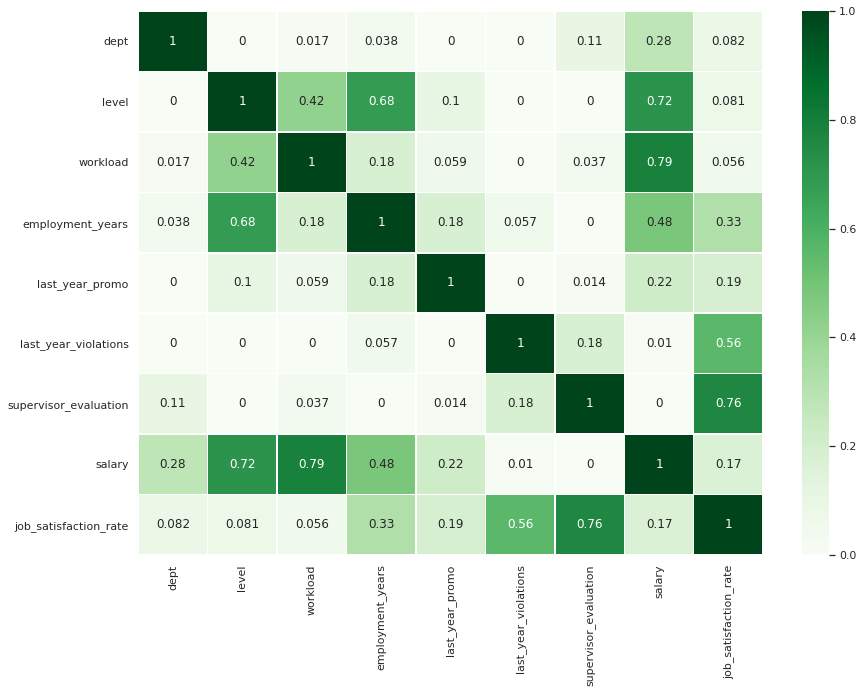

In [15]:
train_job_satisfaction_rate_without_id = train_job_satisfaction_rate.drop(columns=['id'])
plt.figure(figsize=(14, 10))
interval_columns = ['salary', 'job_satisfaction_rate']
sns.heatmap(train_job_satisfaction_rate_without_id.phik_matrix(interval_cols=interval_columns), annot=True, cmap='Greens', linewidths=0.5);

**Вывод:**

**Анализ графиков**

**train_job_satisfaction_rate**

- `dept` - Наибольшими по количеству сотрудников являются отделы продаж (37.8%), технологий (21.6%) и закупок (15.2%).
- `level` - Наиболее распространенными уровнями занимаемых должностей с большим отрывом являются junior (47.4%) и middle (43.6%), в то время как уровень senior встречается всего лишь у 9% сотрудников.
- `workload` - 51.6% сотрудников испытывают среднюю нагрузку, малую нагрузку ощущают 30%, в то время как всего 18.4% сотрудников имеют высокую нагрузку.
- `employment_years` - Более 50% сотрудников компании работают менее 4 лет. 24% сотрудников проработали лишь 1 год, в то время как всего 2.4% сотрудников остаются в компании на протяжении 10 лет.
- `last_year_promo` - Только 3% сотрудников получили повышение в должности за последний год.
- `last_year_violations` - За последнйи год 14% сотрудников нарушили трудовой договор.
- `supervisor_evaluation` - Большинство сотрудников (40.1%) получили оценку 4 по качеству работы, 31.6% имеют оценку 3, 13.7% получили оценку 5, в то время как только 5% сотрудников оценены на уровне 1.
- `salary` - Медианная зарплата составляет 30,000 рублей. 75% сотрудников получают зарплату до 43,200 рублей, при этом максимальная зарплата достигает 98,400 рублей, а минимальная составляет 12,000 рублей.
- `job_satisfaction_rate` - У нашего целевого признака(уровень удовлетворённости сотрудника работой), на графике проявляет две выраженные вершины в районах 0.38 и 0.7. Медианное значение составляет 0.56. Минимальная удовлетворенность сотрудника равна 0.03, в то время как максимальная достигает значения 1.

**test_features + test_target_job_satisfaction_rate**
- Видим, что данные в тестовой выборке очень близки к тренировочным. Это говорит о правильном выделении тестовой выборки, что является важным аспектом для корректного обучения и оценки модели.


**Корреляционный анализ**

Наибольшая корреляция с целевым признаком наблюдается у следующих показателей:

    1) Оценка качества работы сотрудника - 0.76

    2) Нарушение сотрудником трудового договора - 0.56

    3) Продолжительность работы в компании - 0.33

**Мультиколлинеарность не наблюдается** 


## Подготовка пайплайна и обучение модели регрессии 

In [16]:
def smape(y_test, pred):
    metric = np.mean(2 * np.abs(pred - y_test) / (np.abs(y_test) + np.abs(pred))) * 100
    return metric
scorer_smape = make_scorer(smape, greater_is_better=False)

### Подготовка пайплайна

In [17]:
train_job_satisfaction_rate_no_id = train_job_satisfaction_rate.set_index('id')
print(f'Явные дубликаты в train_job_satisfaction_rate_no_id: {train_job_satisfaction_rate_no_id.duplicated().sum()}')
train_job_satisfaction_rate_no_id = train_job_satisfaction_rate_no_id.drop_duplicates()
print(f'Размер df после удаления дубликатов {train_job_satisfaction_rate_no_id.shape[0]}')

Явные дубликаты в train_job_satisfaction_rate_no_id: 245
Размер df после удаления дубликатов 3755


In [18]:
X_train = train_job_satisfaction_rate_no_id.drop(['job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction_rate_no_id['job_satisfaction_rate']

In [19]:
#списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['salary', 'employment_years', 'supervisor_evaluation']


#пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('simpleImputer_ohe_blank', SimpleImputer(missing_values=' ', strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))])
 
#пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
#общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

#итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [
    
    {
     'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
     'models__max_depth': range(2, 25),
     'models__max_features': range(2, 12),
     'models__min_samples_split': [2, 5, 10],  
     'models__min_samples_leaf': [1, 2, 4], 
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
 
    {
     'models': [LinearRegression()],
     'models__fit_intercept': [True, False], 
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
 
]

### Подбор лучшей модели и ее параметров

In [20]:
randomized_search_s = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=scorer_smape,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)
randomized_search_s.fit(X_train, y_train)


print('Лучшая модель и её параметры:\n\n', randomized_search_s.best_estimator_)
print ('Метрика SMAPE лучшей модели на тренировочной выборке:', randomized_search_s.best_score_ * -1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_blank',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                 

In [21]:
result = pd.DataFrame(randomized_search_s.cv_results_)
with pd.option_context('max_colwidth', 3000):
    display(result[['rank_test_score', 'param_models', 'mean_test_score','params']]
            .sort_values('rank_test_score').head(10))

,rank_test_score,param_models,mean_test_score,params
1,1,DecisionTreeRegressor(random_state=42),-15.232730,"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 10, 'models__min_samples_leaf': 2, 'models__max_features': 11, 'models__max_depth': 21, 'models': DecisionTreeRegressor(random_state=42)}"
8,2,DecisionTreeRegressor(random_state=42),-15.460753,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 10, 'models__min_samples_leaf': 2, 'models__max_features': 9, 'models__max_depth': 21, 'models': DecisionTreeRegressor(random_state=42)}"
4,3,DecisionTreeRegressor(random_state=42),-15.633238,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 2, 'models__min_samples_leaf': 4, 'models__max_features': 11, 'models__max_depth': 15, 'models': DecisionTreeRegressor(random_state=42)}"
5,4,DecisionTreeRegressor(random_state=42),-16.023827,"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 5, 'models__min_samples_leaf': 2, 'models__max_features': 6, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=42)}"
2,5,DecisionTreeRegressor(random_state=42),-16.211971,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 10, 'models__min_samples_leaf': 2, 'models__max_features': 5, 'models__max_depth': 21, 'models': DecisionTreeRegressor(random_state=42)}"
9,6,DecisionTreeRegressor(random_state=42),-16.432733,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 10, 'models__min_samples_leaf': 4, 'models__max_features': 5, 'models__max_depth': 18, 'models': DecisionTreeRegressor(random_state=42)}"
3,7,DecisionTreeRegressor(random_state=42),-16.993239,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 10, 'models__min_samples_leaf': 1, 'models__max_features': 4, 'models__max_depth': 21, 'models': DecisionTreeRegressor(random_state=42)}"
6,8,DecisionTreeRegressor(random_state=42),-17.339411,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 2, 'models__min_samples_leaf': 2, 'models__max_features': 4, 'models__max_depth': 23, 'models': DecisionTreeRegressor(random_state=42)}"
7,9,DecisionTreeRegressor(random_state=42),-22.593845,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 10, 'models__min_samples_leaf': 1, 'models__max_features': 9, 'models__max_depth': 3, 'models': DecisionTreeRegressor(random_state=42)}"
0,10,DecisionTreeRegressor(random_state=42),-25.626638,"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 5, 'models__min_samples_leaf': 4, 'models__max_features': 3, 'models__max_depth': 5, 'models': DecisionTreeRegressor(random_state=42)}"


### Проверка модели на тестовой выборке

In [22]:
test_features_target = pd.merge(test_features, test_target_job_satisfaction_rate, on='id', how='left')
X_test = test_features_target.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = test_features_target['job_satisfaction_rate']
y_test_pred = randomized_search_s.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {smape(y_test, y_test_pred)}')

Метрика SMAPE на тестовой выборке: 13.4712946951089


**Вывод: После проведения подбора лучшей модели и её гиперпараметров с использованием RandomizedSearchCV, была выбрана модель DecisionTreeRegressor с оптимальными гиперпараметрами: max_depth = 21, max_features = 11, min_samples_leaf = 2 и min_samples_split = 10.
Мы выбрали метрику SMAPE для оценки работы модели, поскольку она учитывает точность прогнозов в обоих направлениях, устойчива к выбросам и обладает легкой интерпретируемостью. В результате подбора оптимальных параметров удалось достичь значения SMAPE на уровне 15.23% для тренировочной выборки и 13.47% для тестовой, что указывает на высокую точность модели.**

# Вторая задача

## Предобработка данных quit

In [23]:
display(train_quit.sample(5))
train_quit.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3445,304158,sales,middle,high,2,yes,no,4,49200,no
632,932914,sales,junior,medium,4,no,no,5,25200,no
1011,625607,hr,junior,low,3,no,no,4,13200,yes
3828,353258,hr,middle,high,4,no,no,2,54000,no
257,214377,purchasing,sinior,high,1,yes,no,4,67200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [24]:
display(test_target_quit.sample(5))
test_target_quit.info()

,id,quit
773,306487,yes
987,131101,no
903,291640,no
118,421600,no
343,165789,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [25]:
print('train_quit')
for column in train_quit.select_dtypes(include='object').columns:
    unique_values = train_quit[column].unique()
    print(f'Уникальные значения в колонке {column}: {unique_values}')

train_quit
Уникальные значения в колонке dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения в колонке level: ['middle' 'junior' 'sinior']
Уникальные значения в колонке workload: ['high' 'medium' 'low']
Уникальные значения в колонке last_year_promo: ['no' 'yes']
Уникальные значения в колонке last_year_violations: ['no' 'yes']
Уникальные значения в колонке quit: ['no' 'yes']


**Вывод: В новых данных не выявлено пропусков и других аномалий, предобработка не требуется.
Входные признаки тестовой выборки те же, что и в прошлой задаче.**

## Исследовательский анализ данных в разрезе целевого признака

### Исследовательский анализ данных

**Категориальные признаки**

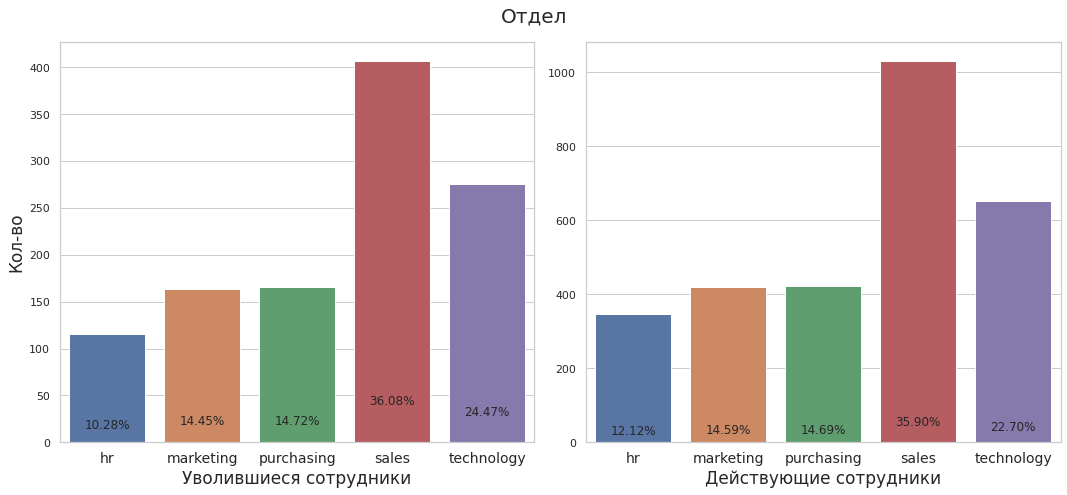

In [26]:
split_barplot('dept', 'Отдел')

Отделы, в которых трудятся уволившиеся и действующие сотрудники, не демонстрируют значимых различий.

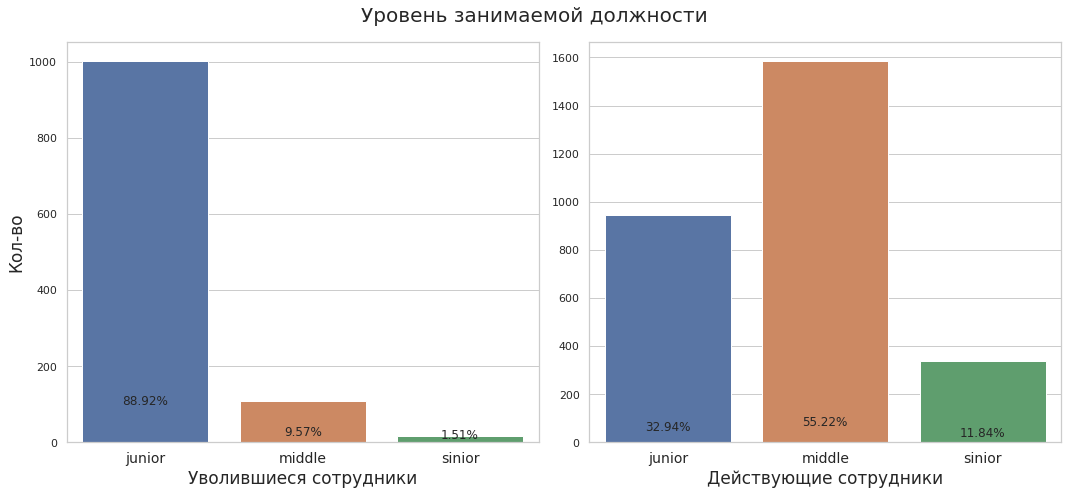

In [27]:
split_barplot('level', 'Уровень занимаемой должности')

Можно отметить существенные различия в уровне занимаемой должности между двумя группами сотрудников. Среди уволившихся сотрудников преобладает уровень "junior" (88.92%), в то время как среди действующих сотрудников преобладает уровень "middle" (55.22%). Уровень "senior" также преобладает среди не уволившихся сотрудников, составляя 11.84%, в сравнении с 1.51% у уволившихся сотрудников.

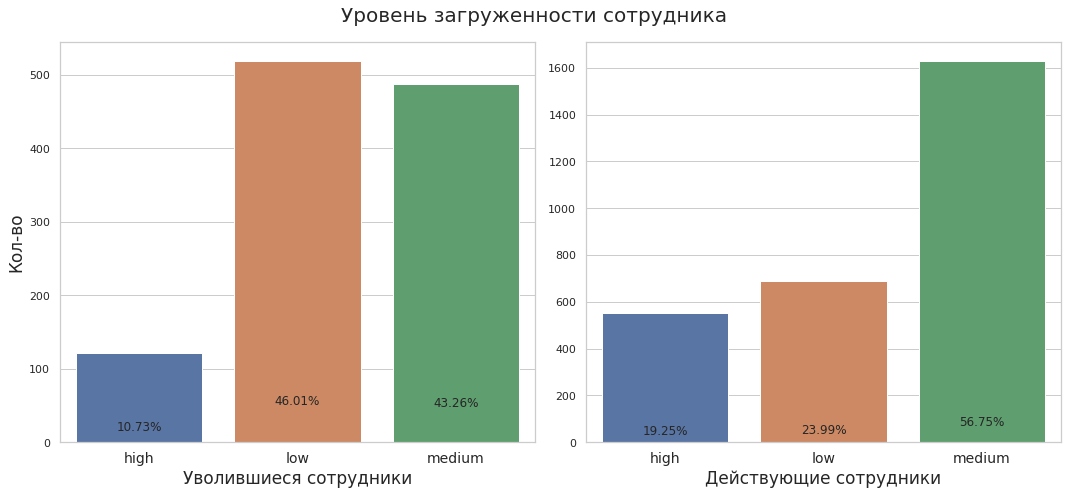

In [28]:
split_barplot('workload', 'Уровень загруженности сотрудника')

Из графиков видно, что основное различие между двумя группами проявляется при низком уровне загруженности – 46% среди уволившихся сотрудников по сравнению с 23% у действующих.

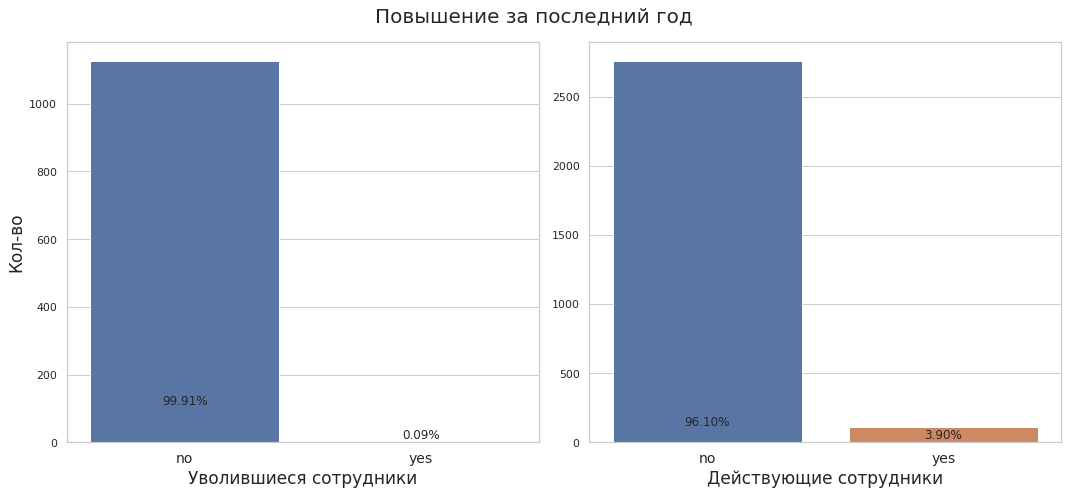

In [29]:
split_barplot('last_year_promo', 'Повышение за последний год')

Повышение за последний год более характерно для действующих сотрудников, составляя 3.9%, в сравнении с 0.09% у уволившихся.

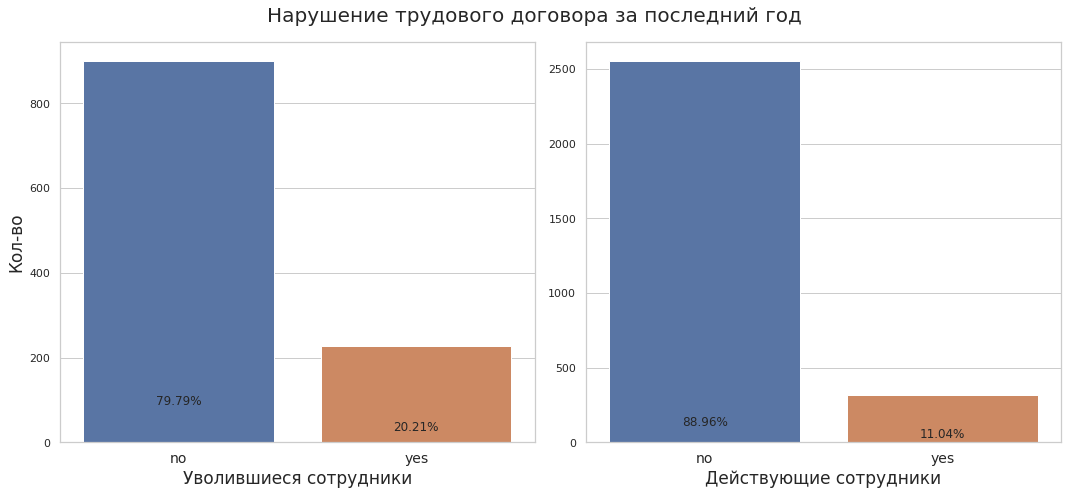

In [30]:
split_barplot('last_year_violations', 'Нарушение трудового договора за последний год')

Уволившиеся сотрудники чаще нарушают трудовой договор, при этом уровень нарушений составляет 20%, в сравнении с 11% у действующих сотрудников.

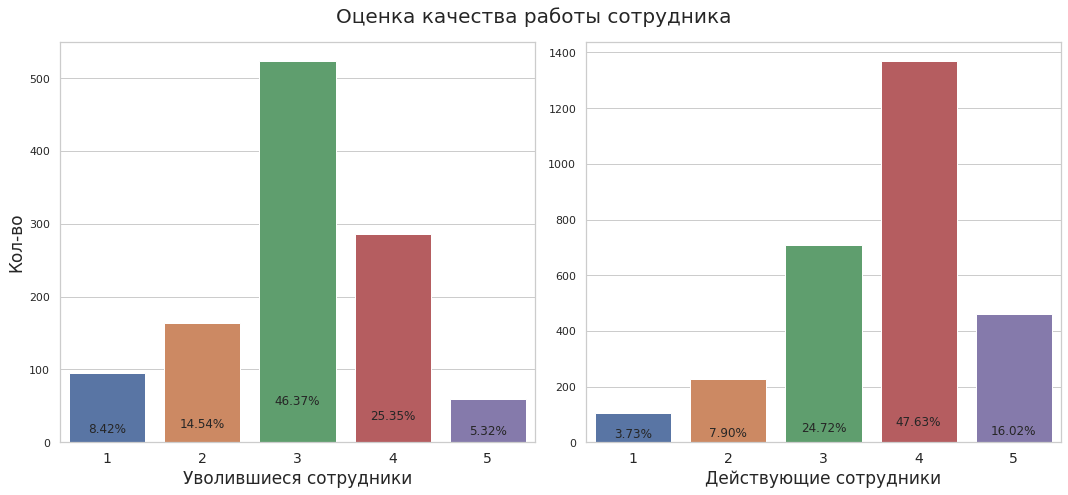

In [31]:
split_barplot('supervisor_evaluation', 'Оценка качества работы сотрудника')

Действующие сотрудники в целом демонстрируют более высокие оценки качества своей работы по сравнению с уволившимися коллегами.
У уволившихся сотрудников преобладает оценка 3, составляя 46%, в то время как у действующих сотрудников преобладает оценка 4, составляя 47%.

**Количественные признаки**

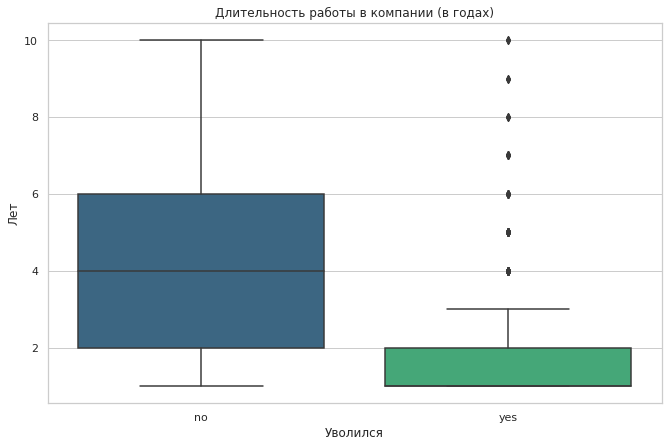

Действующие сотрудники:


count    2872.000000
mean        4.430710
std         2.544635
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


Уволившиеся сотрудники:


count    1128.000000
mean        1.844858
std         1.274920
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: employment_years, dtype: float64

In [32]:
split_boxplot('employment_years', 'Длительность работы в компании (в годах)', 'Лет')
print('Действующие сотрудники:')
display(train_quit.query('quit != "yes"')['employment_years'].describe())
print()
print('Уволившиеся сотрудники:')
train_quit.query('quit == "yes"')['employment_years'].describe()

Проведя анализ длительности работы в компании, можно сказать, что для действующих сотрудников медианное значение трудового стажа составляет 4 года, в то время как для уволившихся медиана снижается до 1. Случаи, когда уволившийся сотрудник проработал более 3,5 лет, крайне редки. Однако можно выделить наблюдения, когда уволившийся сотрудник проработал в компании 10 лет.

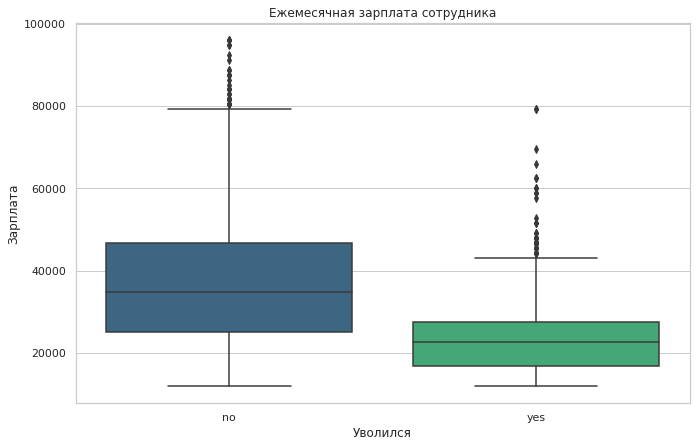

Действующие сотрудники:


count     2872.000000
mean     37702.228412
std      15218.977339
min      12000.000000
25%      25200.000000
50%      34800.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64


Уволившиеся сотрудники:


count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64

In [33]:
split_boxplot('salary', 'Ежемесячная зарплата сотрудника', 'Зарплата')
print('Действующие сотрудники:')
display(train_quit.query('quit != "yes"')['salary'].describe())
print()
print('Уволившиеся сотрудники:')
train_quit.query('quit == "yes"')['salary'].describe()

Медианная зарплата у уволившихся сотрудников составляет 22 800, в сравнении с 34 800 у действующих сотрудников. Также можно выделить, что как минимальная, так и максимальная зарплата также ниже у уволившихся сотрудников.
Вероятно, это может быть связано с тем, что большинство уволившихся сотрудников имели статус junior.

### Портрет «уволившегося сотрудника»

In [34]:
print('Наиболее популярные значения по категориальным признакам от доли уволившихся сотрудников:')
for column in train_quit.select_dtypes(include='object').columns:
    if column != 'quit':
        result = train_quit.groupby([column])['quit'].value_counts(normalize=True)\
                                        .groupby(level=1).idxmax()
        
        result_yes = result[result.index.get_level_values(0) == 'yes'].str[0][0]
        
        print(f'{column}: {result_yes}')
print()
print('Наиболее популярные значения по числовым признакам для уволившихся сотрудников:')
for column in train_quit.select_dtypes(include='int').columns:
    if column != 'id':
        mode_values = train_quit.query('quit == "yes"')[column].median()
        print(f'{column}: {mode_values}')

Наиболее популярные значения по категориальным признакам от доли уволившихся сотрудников:
dept: technology
level: junior
workload: low
last_year_promo: no
last_year_violations: yes

Наиболее популярные значения по числовым признакам для уволившихся сотрудников:
employment_years: 1.0
supervisor_evaluation: 3.0
salary: 22800.0


### Оценка влияния удовлетворённости сотрудника на его увольнение

In [35]:
test_features['job_satisfaction_rate'] = randomized_search_s.predict(test_features)
test_features = test_features.merge(test_target_quit, on='id', how='inner')

In [36]:
interval_columns = ['job_satisfaction_rate', 'salary']
phik_matrix_result = phik.phik_matrix(test_features, interval_cols=interval_columns)
phik_value = phik_matrix_result.loc['quit', 'job_satisfaction_rate']
print(f'Значение Phik между quit и job_satisfaction_rate: {phik_value}');

Значение Phik между quit и job_satisfaction_rate: 0.5824335415384416


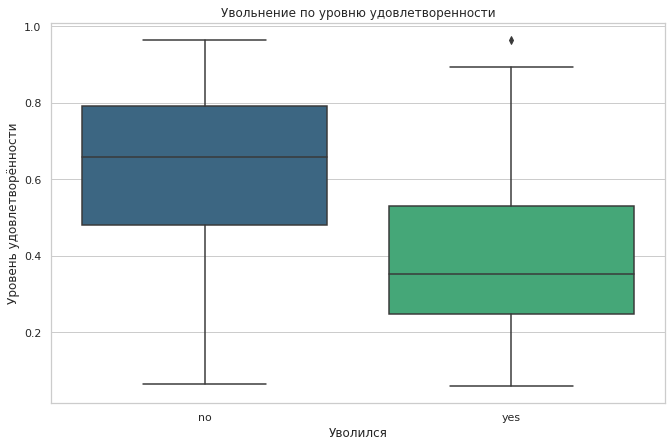

Действующие сотрудники:


count    1436.000000
mean        0.609572
std         0.197956
min         0.065714
25%         0.481667
50%         0.657571
75%         0.792500
max         0.964286
Name: job_satisfaction_rate, dtype: float64


Уволившиеся сотрудники:


count    564.000000
mean       0.399286
std        0.184779
min        0.060000
25%        0.249286
50%        0.352976
75%        0.530000
max        0.964286
Name: job_satisfaction_rate, dtype: float64

In [37]:
plt.figure(figsize=(11, 7)) 

sns.boxplot(x='quit', y='job_satisfaction_rate', data=test_features, palette="viridis")
plt.title('Увольнение по уровню удовлетворенности')
plt.xlabel('Уволился')
plt.ylabel('Уровень удовлетворённости')
 
plt.show()

print('Действующие сотрудники:')
display(test_features.query('quit != "yes"')['job_satisfaction_rate'].describe())
print()
print('Уволившиеся сотрудники:')
test_features.query('quit == "yes"')['job_satisfaction_rate'].describe()

### Добавление нового входного признака job_satisfaction_rate 

In [38]:
train_quit['job_satisfaction_rate'] = randomized_search_s.predict(train_quit)

Мы можем подтвердить наличие связи между уровнем удовлетворенности и увольнением. Коэффициент phik составляет 0.58, что свидетельствует о заметной корреляции. Кроме того, замечаем, что у уволившихся сотрудников уровень удовлетворенности как в целом, так и по медиане, является более низким: 0.35 по сравнению с 0.65 у действующих сотрудников.

**Вывод:**

**Наиболее значимые различия для уволившихся и действующих сотрудников:**
- Среди уволившихся сотрудников преобладает уровень "junior" (88.92%), в то время как среди действующих сотрудников преобладает уровень "middle" (55.22%).
- Среди уволившихся сотрудников преобладает уровнь загруженности "низкий" (46%), в то время как среди действующих сотрудников преобладает "medium" 56%.
- У уволившихся сотрудников почти не было повышений за последний год.
- Уволившиеся сотрудники чаще нарушают трудовой договор, при этом уровень нарушений составляет 20%, в сравнении с 11% у действующих сотрудников.
- Действующие сотрудники в целом демонстрируют более высокие оценки качества своей работы по сравнению с уволившимися коллегами.

**Портрет уволившегося сотрудника:**
- Отдел - technology
- Уровень занимаемой должности - junior
- Загруженность - низкая
- Повышение за последний год - нет
- Нарушал трудовой договор - да
- Длительность работы в компании - 1 год
- Оценка качества работы - 3
- Ежемесячная зарплата - 22800

**Оценка влияния удовлетворённости сотрудника на его увольнение**

Мы успешно подтвердили наличие связи между уровнем удовлетворенности сотрудника и фактом увольнения. Это обоснование позволило внести новый показатель `job_satisfaction_rate` в тренировочные данные `train_quit`.

## Подготовка пайплайна и обучение модели классификации

### Подготовка пайплайна

In [39]:
train_quit_no_id = train_quit.set_index('id')
print(f'Явные дубликаты в train_job_satisfaction_rate_no_id: {train_quit_no_id.duplicated().sum()}')
train_quit_no_id = train_quit_no_id.drop_duplicates()
print(f'Размер df после удаления дубликатов {train_quit_no_id.shape[0]}')
train_quit['quit'] = train_quit['quit'].apply(lambda x: 0 if x == 'no' else 1)

X_train = train_quit_no_id.drop(['quit'], axis=1)
y_train = train_quit_no_id['quit']

Явные дубликаты в train_job_satisfaction_rate_no_id: 1413
Размер df после удаления дубликатов 2587


In [40]:
#списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['salary', 'employment_years', 'job_satisfaction_rate', 'supervisor_evaluation']


#пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('simpleImputer_ohe_blank', SimpleImputer(missing_values=' ', strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))])

#пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

#общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

#итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', KNeighborsClassifier())
])


param_grid = [
    
    {
     'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
     'models__min_samples_split': range(2, 22),
     'models__min_samples_leaf': range(1, 22),
     'models__max_depth': range(2, 22),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
 
    {
     'models': [KNeighborsClassifier()],
     'models__n_neighbors': range(2,8),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
 
    {
     'models': [LogisticRegression(
        random_state=RANDOM_STATE, 
        solver='liblinear', 
        penalty='l1')],
     'models__C': range(1,8),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
 
]

### Подбор лучшей модели и ее параметров

In [41]:
randomized_search_q = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_q.fit(X_train, y_train)


print('Лучшая модель и её параметры:\n\n', randomized_search_q.best_estimator_)
print ('Метрика ROC-AUC лучшей модели на тренировочной выборке:', randomized_search_q.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_blank',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                 

In [42]:
result_q = pd.DataFrame(randomized_search_q.cv_results_)
with pd.option_context('max_colwidth', 3000):
    display(result_q[['rank_test_score', 'param_models', 'mean_test_score','params']]
            .sort_values('rank_test_score').head(10))

,rank_test_score,param_models,mean_test_score,params
8,1,DecisionTreeClassifier(random_state=42),0.896443,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 10, 'models__min_samples_leaf': 21, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
7,2,DecisionTreeClassifier(random_state=42),0.892663,"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 14, 'models__min_samples_leaf': 12, 'models__max_depth': 19, 'models': DecisionTreeClassifier(random_state=42)}"
1,3,DecisionTreeClassifier(random_state=42),0.892581,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 7, 'models__min_samples_leaf': 12, 'models__max_depth': 14, 'models': DecisionTreeClassifier(random_state=42)}"
0,4,DecisionTreeClassifier(random_state=42),0.892530,"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 6, 'models__min_samples_leaf': 17, 'models__max_depth': 20, 'models': DecisionTreeClassifier(random_state=42)}"
6,5,DecisionTreeClassifier(random_state=42),0.891980,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 3, 'models__min_samples_leaf': 21, 'models__max_depth': 10, 'models': DecisionTreeClassifier(random_state=42)}"
3,6,DecisionTreeClassifier(random_state=42),0.890190,"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 18, 'models__min_samples_leaf': 6, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
5,7,DecisionTreeClassifier(random_state=42),0.889347,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 10, 'models__min_samples_leaf': 11, 'models__max_depth': 11, 'models': DecisionTreeClassifier(random_state=42)}"
9,8,DecisionTreeClassifier(random_state=42),0.888261,"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 18, 'models__min_samples_leaf': 8, 'models__max_depth': 15, 'models': DecisionTreeClassifier(random_state=42)}"
4,9,DecisionTreeClassifier(random_state=42),0.878214,"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 13, 'models__min_samples_leaf': 3, 'models__max_depth': 19, 'models': DecisionTreeClassifier(random_state=42)}"
2,10,DecisionTreeClassifier(random_state=42),0.876122,"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 8, 'models__min_samples_leaf': 15, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"


### Проверка модели на тестовой выборке 

In [43]:
X_test = test_features.drop(['quit'], axis=1)
y_test = test_features['quit']
y_test_pred = randomized_search_q.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.9248898634899938


### Анализ важности признаков

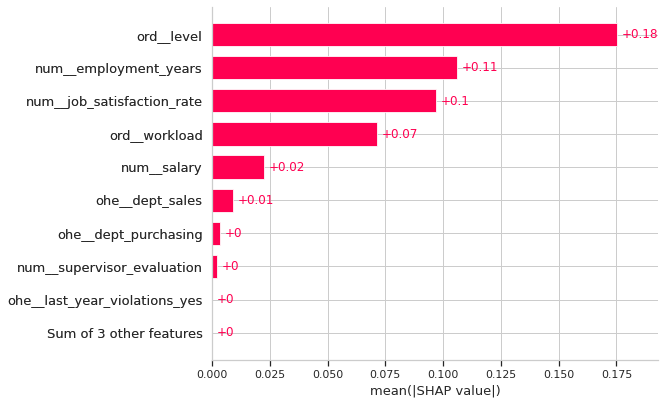

None

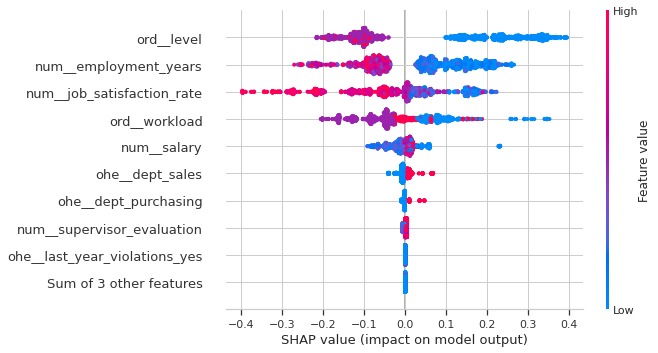

In [44]:
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
explainer = shap.Explainer(randomized_search_q.best_estimator_.named_steps['models'], X_train_2)
X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)
shap_values = explainer(X_test_2)[:, :, 1]
display(shap.plots.bar(shap_values))
shap.plots.beeswarm(shap_values) 

**Вывод: После проведения подбора лучшей модели и её гиперпараметров с использованием RandomizedSearchCV, была выбрана модель DecisionTreeClassifier с оптимальными гиперпараметрами: max_depth=6, min_samples_leaf = 21 и min_samples_split = 10.
В качестве метрики для оценки производительности модели мы выбрали roc_auc, поскольку эта метрика считается наиболее универсальной и информативной при решении задач классификации. Нам удалось достичь значения 89 на обучающей выборке и 92 на тестовой. Эти результаты свидетельствуют о эффективности нашей модели в решении поставленной задачи.**

**Наиболее важными для модели признаками оказались:**
- level
- emoloyment_years
- job_satifaction_rate


## Общий вывод

### Задача исследования:
Задача данного исследования заключается в разработке двух моделей с использованием машинного обучения для оптимизации управления персоналом в компании "Работа с Заботой".

Первая задача: Построение модели, способной предсказывать уровень удовлетворенности сотрудника на основе предоставленных данных о характеристиках сотрудников. Эта модель поможет бизнесу быстро и точно оценивать уровень удовлетворенности сотрудников, что имеет прямое влияние на отток персонала.

Вторая задача: Разработка модели, способной предсказывать вероятность увольнения сотрудника на основе данных заказчика. Это предсказание оттока является важным инструментом для HR-аналитиков, поскольку позволяет предотвращать внезапные увольнения, которые могут повлечь за собой риски для компании.

Обе модели направлены на улучшение управления персоналом, оптимизацию бизнес-процессов и снижение рисков, связанных с оттоком сотрудников.
    
    
### Этапы исследования:

- **Первая задача**

1. **Загрузка данных:**

    В ходе анализа основной информации о датафреймах было выявлено наличие пропущенных значений в столбцах `dept` и `level` как в тестовой, так и в тренировочной выборке.
    
    
    
2. **Предобработка данных satisfaction:** 

    На этапе предобработки была проведена проверка на наличие дубликатов, которые не были выявлены. Также была осуществлена проверка вариативности записей, в результате чего выявлены некорректно внесенные данные в тестовой выборке, а именно в столбцах `dept` и `workload`.
    
    
    
3. **Исследовательский анализ данных:**

    
- `dept` - Наибольшими по количеству сотрудников являются отделы продаж (37.8%), технологий (21.6%) и закупок (15.2%).
- `level` - Наиболее распространенными уровнями занимаемых должностей с большим отрывом являются junior (47.4%) и middle (43.6%), в то время как уровень senior встречается всего лишь у 9% сотрудников.
- `workload` - 51.6% сотрудников испытывают среднюю нагрузку, малую нагрузку ощущают 30%, в то время как всего 18.4% сотрудников имеют высокую нагрузку.
- `employment_years` - Более 50% сотрудников компании работают менее 4 лет. 24% сотрудников проработали лишь 1 год, в то время как всего 2.4% сотрудников остаются в компании на протяжении 10 лет.
- `last_year_promo` - Только 3% сотрудников получили повышение в должности за последний год.
- `last_year_violations` - За последнйи год 14% сотрудников нарушили трудовой договор.
- `supervisor_evaluation` - Большинство сотрудников (40.1%) получили оценку 4 по качеству работы, 31.6% имеют оценку 3, 13.7% получили оценку 5, в то время как только 5% сотрудников оценены на уровне 1.
- `salary` - Медианная зарплата составляет 30,000 рублей. 75% сотрудников получают зарплату до 43,200 рублей, при этом максимальная зарплата достигает 98,400 рублей, а минимальная составляет 12,000 рублей.
- `job_satisfaction_rate` - У нашего целевого признака(уровень удовлетворённости сотрудника работой), на графике проявляет две выраженные вершины в районах 0.38 и 0.7. Медианное значение составляет 0.56. Минимальная удовлетворенность сотрудника равна 0.03, в то время как максимальная достигает значения 1.
   
  Наибольшая корреляция с целевым признаком наблюдается у следующих показателей:
    
      1) Оценка качества работы сотрудника - 0.76
      2) Нарушение сотрудником трудового договора - 0.56
      3) Продолжительность работы в компании - 0.33
    
  Мультиколлинеарность не наблюдается

4. **Подготовка пайплайна и обучение модели регрессии**

     После проведения подбора лучшей модели и её гиперпараметров с использованием RandomizedSearchCV, была выбрана модель DecisionTreeRegressor с оптимальными гиперпараметрами: max_depth = 21, max_features = 11, min_samples_leaf = 2 и min_samples_split = 10. Мы выбрали метрику SMAPE для оценки работы модели, поскольку она учитывает точность прогнозов в обоих направлениях, устойчива к выбросам и обладает легкой интерпретируемостью. В результате подбора оптимальных параметров удалось достичь значения SMAPE на уровне 15.23% для тренировочной выборки и 13.47% для тестовой, что указывает на высокую точность модели.
 
- **Вторая задача**
  
  
5. **Предобработка данных quit:**

    В новых данных не выявлено пропусков и других аномалий.
    
    
6. **Исследовательский анализ данных в разрезе целевого признака**

    Наиболее значимые различия для уволившихся и действующих сотрудников:
    
- Среди уволившихся сотрудников преобладает уровень "junior" (88.92%), в то время как среди действующих сотрудников преобладает уровень "middle" (55.22%).
- Среди уволившихся сотрудников преобладает уровнь загруженности "низкий" (46%), в то время как среди действующих сотрудников преобладает "medium" 56%.
- У уволившихся сотрудников почти не было повышений за последний год.
- Уволившиеся сотрудники чаще нарушают трудовой договор, при этом уровень нарушений составляет 20%, в сравнении с 11% у действующих сотрудников.
- Действующие сотрудники в целом демонстрируют более высокие оценки качества своей работы по сравнению с уволившимися коллегами.
    
    Портрет уволившегося сотрудника:
    
    
    - Отдел - technology
    - Уровень занимаемой должности - junior
    - Загруженность - низкая
    - Повышение за последний год - нет
    - Нарушал трудовой договор - да
    - Длительность работы в компании - 1 год
    - Оценка качества работы - 3
    - Ежемесячная зарплата - 22800
    
    Оценка влияния удовлетворённости сотрудника на его увольнение:
    
    Мы успешно подтвердили наличие связи между уровнем удовлетворенности сотрудника и фактом увольнения. Это обоснование позволило внести новый показатель `job_satisfaction_rate` в тренировочные данные `train_quit`.
    
    
7. **Подготовка пайплайна и обучение модели классификации**
    
    После проведения подбора лучшей модели и её гиперпараметров с использованием RandomizedSearchCV, была выбрана модель DecisionTreeClassifier с оптимальными гиперпараметрами: max_depth = 6, min_samples_leaf = 21 и min_samples_split = 10. В качестве метрики для оценки производительности модели мы выбрали roc_auc, поскольку эта метрика считается наиболее универсальной и информативной при решении задач классификации. Нам удалось достичь значения 89 на обучающей выборке и 92 на тестовой. Эти результаты свидетельствуют о эффективности нашей модели в решении поставленной задачи.

    Наиболее важными для модели признаками оказались:

    - level
    - employment_years
    - job_satifaction_rate

### Выводы и предложения
Общие выводы и предложения включают в себя несколько ключевых моментов. Важность оценки удовлетворенности сотрудников подтверждена. Предложенные модели успешно обучены и демонстрируют высокую точность. Рекомендуется внедрение системы мониторинга данных о сотрудниках для оперативного выявления проблем и принятия мер.

Такие практики, как регулярные обзоры загруженности, повышений и оценок качества работы, могут значительно улучшить эффективность управления персоналом. Введение программ стимулирования и мотивации сотрудников также является важным шагом для увеличения удовлетворенности и снижения риска оттока.